# Congruent number classification and prediction using arithmetic features


The notebook contains ML experiments to classify and predict congruent numnbers. We use residue modulo $8, 16, 32$ and the number prime factors as features. The following ML models are used

- logistic regression,
- random forest,
- gradient boost,
- XGboost,
- descision tree classifier.


In [8]:
import pandas as pd

# --- Configuration ---

file = "data_with_mod8.csv"

# Specify the columns to keep from each file (including 'n')
cols_file = ["n", "iscongruent", "mod8"]  # Replace with actual column names from file1


df = pd.read_csv(file, usecols=cols_file)

# --- Result ---


df['mod16'] = df["n"] % 16
df['mod32'] = df['n'] % 32

print(df.head())  # preview

# Optional: save to a new CSV
#combined_df.to_csv("cn_pred_selmer.csv")


   n  iscongruent  mod8  mod16  mod32
0  1            0     1      1      1
1  2            0     2      2      2
2  3            0     3      3      3
3  6            1     6      6      6
4  5            1     5      5      5


In [12]:
import math

def count_distinct_prime_factors(n):
    count = 0
    # Check for factor 2
    if n % 2 == 0:
        count += 1
        while n % 2 == 0:
            n //= 2
    # Check for odd factors up to sqrt(n)
    for i in range(3, int(math.isqrt(n)) + 1, 2):
        if n % i == 0:
            count += 1
            while n % i == 0:
                n //= i
    # If remainder is a prime factor > 2
    if n > 1:
        count += 1
    return count

# Example usage:
#number = 210  # Square-free example: 2 * 3 * 5 * 7
#print(count_distinct_prime_factors(number))  # Output: 4
df["omegad"] = df["n"].apply(count_distinct_prime_factors)

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


print(df)

len_0 = min(df[df['iscongruent'] == 0].shape[0], 70000)
df_balanced = df[df['iscongruent'] == 1].sample(len_0) 
df_balanced1 = df[df['iscongruent'] == 0].sample(len_0) 
df_balanced = pd.concat([df_balanced, df_balanced1])
print(df_balanced.iscongruent.value_counts())

# === Features and target ===
feature_cols = ["mod8", "mod16", "mod32", "omegad"]
X = df_balanced[feature_cols]
y = df_balanced['iscongruent']

             n  iscongruent  mod8  mod16  mod32  omegad
0            1            0     1      1      1       0
1            2            0     2      2      2       1
2            3            0     3      3      3       1
3            6            1     6      6      6       2
4            5            1     5      5      5       1
...        ...          ...   ...    ...    ...     ...
607921  999989            1     5      5     21       2
607922  999991            1     7      7     23       3
607923  999993            0     1      9     25       2
607924  999995            0     3     11     27       2
607925  999997            1     5     13     29       2

[607926 rows x 6 columns]
iscongruent
1    70000
0    70000
Name: count, dtype: int64


In [40]:
# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Feature scaling ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [41]:
# === Models to train ===
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'DTC': DecisionTreeClassifier()
}


Logistic Regression
Accuracy:  0.9583
Precision: 0.9976
Recall:    0.9187
F1 Score:  0.9565
ROC AUC:   0.9606


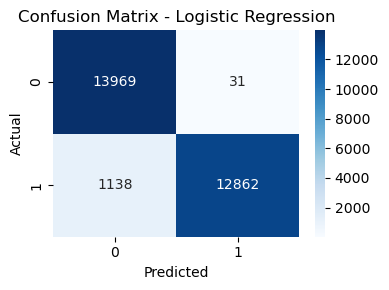


Random Forest
Accuracy:  0.9588
Precision: 0.9997
Recall:    0.9179
F1 Score:  0.9570
ROC AUC:   0.9741


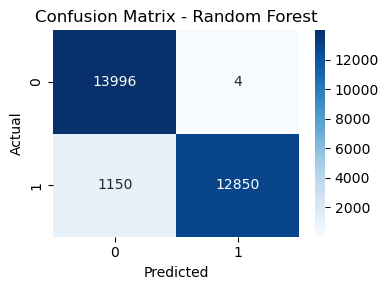


Gradient Boosting
Accuracy:  0.9588
Precision: 1.0000
Recall:    0.9176
F1 Score:  0.9571
ROC AUC:   0.9739


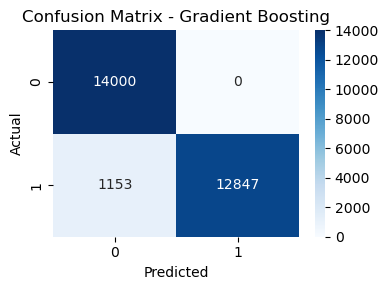


XGBoost
Accuracy:  0.9588
Precision: 0.9997
Recall:    0.9179
F1 Score:  0.9570
ROC AUC:   0.9741


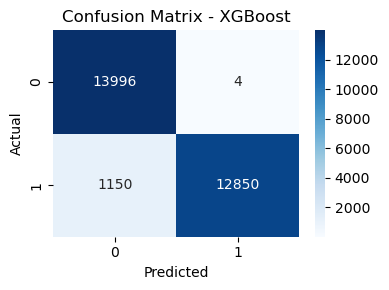


DTC
Accuracy:  0.9588
Precision: 0.9997
Recall:    0.9179
F1 Score:  0.9570
ROC AUC:   0.9741


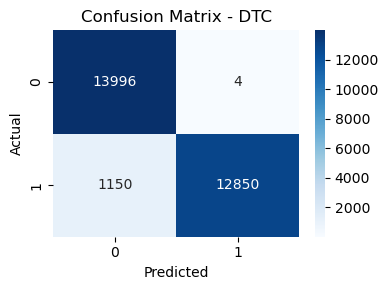

In [42]:
# === Train and evaluate ===
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]  # needed for ROC AUC

    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{name}")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")

    # Confusion Matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()